In [1]:
import numpy as np
import pandas as pd
import altair as alt

import datetime as dt
from scipy import stats
import pymc3 as pm
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import graphviz

In [17]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [10]:
t = data = np.arange(0, 1, 1 / 1_000)
a = 0.7
b = 0.3
c = 0.2
d = 0 #.5
y = a * (t - d) ** 2 + b * (t - d) + c

df = pd.DataFrame(columns=["t", "y"], data=np.array([t, y]).T)

alt.Chart(df).mark_line().encode(
    x='t',
    y='y',
)

alt.Chart(...)

In [11]:
# order
n = 2
exponents = np.arange(n+1)
exponents

array([0, 1, 2])

In [12]:
[print(chr(c), end=" ") for c in range(ord("α"), ord("ω")+1)];

α β γ δ ε ζ η θ ι κ λ μ ν ξ ο π ρ ς σ τ υ φ χ ψ ω 

In [18]:
def polynom_drift(t, n=2):
    with m:
        δ = pm.Uniform("δ", 0, 1)
        β = pm.Uniform("β", -1, 1, shape=n + 1)

        exponents = tt.arange(n + 1)
        X = tt.power(np.array([t]).T - δ, exponents)

        p = det_dot(X, β)
    return p, δ, β

In [19]:
m = pm.Model()

with m:
    p, δ, β = polynom_drift(df["t"], n=2)
    
    ε = pm.HalfCauchy('ε', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=p,
                 sd=ε,
                 observed=df['y'])

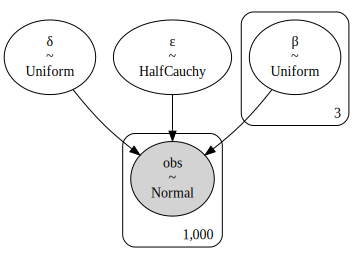

In [20]:
pm.model_to_graphviz(m)

In [21]:
with m:
    trace = pm.sample(250, init="adapt_diag")
    pm.plot_trace(trace)

/var/folders/x1/zy5w8mx91sn2pfxz621kvw0m0000gp/T/ipykernel_15252/299690826.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(250, init="adapt_diag")
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, δ]


/usr/local/Caskroom/miniconda/base/envs/spark/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/Caskroom/miniconda/base/envs/spark/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/usr/local/Caskroom/miniconda/base/envs/spark/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/Caskroom/miniconda/base/envs/spark/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/usr/local/Caskroom/miniconda/base/envs/spark/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:224:

RuntimeError: Chain 0 failed.

In [ ]:
y = pm.sample_prior_predictive(model=m, var_names=['obs'])
y

In [ ]:
t.shape

In [ ]:
X = np.power(t[:,None], powers)

In [ ]:
X = np.power(t[:, None] -.5, exponents)
X

In [ ]:
det_dot(X, np.array([1, 3 , 4]))

In [ ]:
import os
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import datetime as dt
import re

import altair as alt
alt.data_transformers.disable_max_rows();

## Are all DALI boxes (vestiging==Breda) in metadata?

In [ ]:
BOXID = [
    "133.195-1",
    "027.4090-1",
    "133.134-1",
    "178.518-1",
    "053.746-1",
#     "133.141-1", NOT AVAILABLE
    "027.0380-1",
    "133.301-1",
#     "027.2100-1", NOT AVAILABLE
#     "027.4390-1", NOT AVAILABLE
]

## Conclusion: 
7/10 Missing.

In [ ]:
df_sample = pd.DataFrame()
for ID in BOXID:
    df_sample = df_sample.append(
        pd.read_parquet(path = f"../data/raw/BOXID={ID}/L=sumli/").assign(BOXID=ID)
    )
    
df_sample

## Is min or max value robust enough?

In [ ]:
# query data an reformat it
n_extremes=2
i=2

df_top = df_sample.query(f"TOP <= {n_extremes}").rename(columns = {'TOP': 'EXTREME'})
df_bottom = df_sample.query(f"BOTTOM >= -{n_extremes}").rename(columns = {'BOTTOM': 'EXTREME'})
df_extreme = (
    pd.concat([df_top, df_bottom], axis=0)
    .drop(columns=["TOP", "BOTTOM"])
    .sort_values(["YEAR", "WEEK"])
)
df_extreme["DATE"] =  df_extreme.apply(lambda d: dt.datetime.fromisocalendar(d["YEAR"], d["WEEK"], 1), axis=1)
df_extreme

In [ ]:
# plot result
input_dropdown = alt.binding_select(options=BOXID)
selection = alt.selection_single(fields=['BOXID'], bind=input_dropdown, name='Select DALI on', init={"BOXID":BOXID[0]})
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))
(
    alt.Chart(df_extreme)
    .mark_line(point=True)
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli"),
        color=alt.Color("EXTREME:N", sort=list(range(1,10)) + list(range(-9,0, 1))),
        opacity=opacity,
        tooltip=alt.Tooltip(["BOXID", "DATE:T"])
    )
    .transform_filter(selection)
    .add_selection(selection)
    .properties(width=800)
).interactive()

## Conclusion: 
- No need to take second extreme, min and max will do fine, since data is already 15 min average week extremes.
- Data availability/history is something to keep in mind.
- Grid alternations could be problematic if no metadata about it is logged...

# First model based on box "133.134-1"

In [ ]:
import datetime as dt
from scipy import stats
import pymc3 as pm
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import graphviz

### Data Selection and prepping

In [ ]:
BOX_ID = "133.134-1"
df_min = df_extreme.query(f"BOXID == '{BOX_ID}' & EXTREME == -1")
df_max = df_extreme.query(f"BOXID == '{BOX_ID}' & EXTREME == 1")

def format_ts(df):
    df = df.set_index("DATE")["VALUE"].sort_index()
    return df.resample('7D').interpolate()

In [ ]:
ts = format_ts(df_max)

In [ ]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [ ]:
class MinMaxScaler():
    def __init__(self):
        self.min = None
        self.max = None
        
    def fit(self, data):
        self.min = data.min()
        self.max = data.max()
        
    def check_fit(self):
        if self.max is None:
            raise Exception("Can't use transform without fit first!")
        
    def transform(self, data):
        self.check_fit()
        return ((data - self.min) / (self.max - self.min)).astype(float)
        
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, data):
        self.check_fit()
        return data * (self.max - self.min) + self.min

In [ ]:
df = ts.reset_index()
date_scaler, value_scaler = MinMaxScaler(), MinMaxScaler()


df["SCALED_DATE"] = date_scaler.fit_transform(df["DATE"].apply(dt.datetime.timestamp))
value_scaler.fit(df["VALUE"])
value_scaler.min = 0
df["SCALED_VALUE"] = value_scaler.transform(df["VALUE"])
# observed_index = ts.index.map(dt.datetime.timestamp)
df

In [ ]:
def trend_model(m, t, n_changepoints=2, changepoints_prior_scale=0.1, 
                growth_prior_scale=1, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s

In [ ]:
# Generate a PyMC3 Model context
m = pm.Model()
observed_timestamps = df["SCALED_DATE"].values
observed_values = df["SCALED_VALUE"].values
n_changepoints = 4

with m:
    y, A, s = trend_model(m, observed_timestamps, n_changepoints)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=observed_values)
    
pm.model_to_graphviz(m)

In [ ]:
def sanity_check(m, observations):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m)['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(observations, label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, observed_values)

In [ ]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], observed_timestamps, s, A)
g_rescaled = value_scaler.inverse_transform(g)

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g_rescaled)
plt.scatter(np.arange(df.shape[0]), df["VALUE"], s=0.5, color='black');

In [ ]:
def fourier_series(t, p=52.1775, n=5):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [ ]:
# weeks per year
P = 52.1775
P_scaled = P / len(df)
def seasonality_model(m, timestamps, period=P_scaled, n=5, seasonality_prior_scale=10):
    
    x = fourier_series(timestamps, p=period, n=n)
    with m:
        beta = pm.Normal('beta_yearly', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

In [ ]:
m = pm.Model()
with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, observed_timestamps, changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, observed_timestamps, P_scaled, n=5)
    
    y += det_dot(x_yearly, beta_yearly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=observed_values)
pm.model_to_graphviz(m)

In [ ]:
with m:
    trace = pm.sample(500, return_inferencedata=False)
# pm.traceplot(trace);
pm.plot_trace(trace);

In [ ]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.01
# vector distributions
beta_yearly = trace['beta_yearly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * observed_timestamps[:, None] + m + np.dot(A, (-s * delta).T))
trend_posterior_rescaled = value_scaler.inverse_transform(trend_posterior)

yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly)
yearly_posterior_rescaled = value_scaler.inverse_transform(yearly_posterior)

date = df['DATE'].dt.to_pydatetime()
# sunday = np.argmax(df['ds'].dt.dayofweek)
# weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['DATE'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))

plt.subplot(311)
plt.title('total')
total = trend_posterior_rescaled + yearly_posterior_rescaled
quant_total = np.quantile(total, [p, 1 - p], axis=1)
plt.fill_between(date, quant_total[0, :], quant_total[1, :], alpha=0.25)
plt.plot(date, total.mean(1))
plt.scatter(date, df['VALUE'], s=0.5, color='black')

plt.subplot(312)
plt.title('trend')
quant_trend = np.quantile(trend_posterior_rescaled, [p, 1 - p], axis=1)
plt.fill_between(date, quant_trend[0, :], quant_trend[1, :], alpha=0.25)
plt.plot(date, trend_posterior_rescaled.mean(1))

plt.subplot(313)
plt.title('yearly')
quant_yearly = np.quantile(yearly_posterior_rescaled, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 52],
                 quant_yearly[0, idx_year: idx_year + 52], quant_yearly[1, idx_year: idx_year + 52], alpha=0.25)
plt.plot(date[idx_year: idx_year + 52], yearly_posterior_rescaled.mean(1)[idx_year: idx_year + 52]);

## Forecast attempt

In [ ]:
weeks = 25
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

total_period = pd.DataFrame(
    {
        "DATE": pd.date_range(
            df["DATE"].min(),
            df["DATE"].max() + pd.Timedelta(weeks, "W"),
            freq="W",
        )
    }
)
total_period["SCALED_DATE"] = date_scaler.transform(total_period["DATE"].apply(dt.datetime.timestamp))

# vector distributions
beta_yearly = trace['beta_yearly'] #.mean(0)
n_samples = beta_yearly.shape[0]
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

future = total_period["SCALED_DATE"][total_period["SCALED_DATE"] > 1].values


for n in range(n_samples):
    sample = np.random.random(future.shape)
    new_changepoints = future[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (total_period["SCALED_DATE"].values[:, None] > new_s) * 1

    trend_forecast_sample = ((k + np.dot(new_A, new_delta)) * total_period["SCALED_DATE"]  + (m + np.dot(new_A, (-new_s * new_delta))))
    trend_forecast.append(trend_forecast_sample)
    
trend_forecast_rescaled = value_scaler.inverse_transform(np.array(trend_forecast).T)
    
# calculate seasonality for future
new_x_yearly = fourier_series(total_period["SCALED_DATE"].values, p=P_scaled)
new_yearly_posterior = det_seasonality_posterior(beta_yearly, new_x_yearly)
yearly_forecast_rescaled = value_scaler.inverse_transform(new_yearly_posterior)
history = total_period["SCALED_DATE"] <= 1
yearly_forecast_rescaled[history, :] = yearly_forecast_rescaled[history, :].mean(1)[:,None].repeat(n_samples,1)
    
total_forecast_rescaled = trend_forecast_rescaled + yearly_forecast_rescaled

date = total_period["DATE"].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Forecast with uncertainty')
plt.plot(date, total_forecast_rescaled.mean(1))
quant = np.quantile(total_forecast_rescaled, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25);

In [ ]:
weeks = 25
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

total_period = pd.DataFrame(
    {
        "DATE": pd.date_range(
            df["DATE"].min(),
            df["DATE"].max() + pd.Timedelta(weeks, "W"),
            freq="W",
        )
    }
)
total_period["SCALED_DATE"] = date_scaler.transform(total_period["DATE"].apply(dt.datetime.timestamp))

# vector distributions
beta_yearly = trace['beta_yearly'] #.mean(0)
n_samples = beta_yearly.shape[0]
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

future = total_period["SCALED_DATE"][total_period["SCALED_DATE"] > 1].values


for n in range(n_samples):
    sample = np.random.random(future.shape)
    new_changepoints = future[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (total_period["SCALED_DATE"].values[:, None] > new_s) * 1

    trend_forecast_sample = ((k + np.dot(new_A, new_delta)) * total_period["SCALED_DATE"]  + (m + np.dot(new_A, (-new_s * new_delta))))
    trend_forecast.append(trend_forecast_sample)
    
trend_forecast_rescaled = value_scaler.inverse_transform(np.array(trend_forecast).T)
    
# calculate seasonality for future
new_x_yearly = fourier_series(total_period["SCALED_DATE"].values, p=P_scaled)
new_yearly_posterior = det_seasonality_posterior(beta_yearly, new_x_yearly)
yearly_forecast_rescaled = value_scaler.inverse_transform(new_yearly_posterior)
history = total_period["SCALED_DATE"] <= 1
yearly_forecast_rescaled[history, :] = yearly_forecast_rescaled[history, :].mean(1)[:,None].repeat(n_samples,1)
    
total_forecast_rescaled = trend_forecast_rescaled + yearly_forecast_rescaled

date = total_period["DATE"].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Forecast with uncertainty')
plt.plot(date, total_forecast_rescaled.mean(1))
quant = np.quantile(total_forecast_rescaled, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25);

In [ ]:
df

In [ ]:
df_forecast = pd.DataFrame(
    index=total_period["DATE"][-len(future)-1:],
    columns=["LOWER", "MEAN", "UPPER"],
    data=np.quantile(total_forecast_rescaled[-len(future)-1:], [p, .5, 1 - p], axis=1).T
).reset_index()
df_forecast.iloc[0, 1:] = np.repeat(df["VALUE"].iloc[-1], 3)

In [ ]:
alt_observed = (
    alt.Chart(df)
    .mark_line(point=True)
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli"),
        tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
).interactive()

alt_forecasted_band = (
    alt.Chart(df_forecast)
    .mark_errorband(color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("UPPER:Q"),
        y2="LOWER:Q",
    )
    .properties(width=800)
)

alt_forecasted_mean = (
    alt.Chart(df_forecast)
    .mark_line(color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("MEAN:Q", title=f"P sumli max"),
    )
    .properties(width=800)
).interactive()

alt_observed + alt_forecasted_band + alt_forecasted_mean

## with historical data plot

In [ ]:
# #not using since offset !!!
# weeks = 25
# history_points = df.shape[0]
# probability_changepoint = n_changepoints / history_points

# total_period = pd.DataFrame(
#     {
#         "DATE": pd.date_range(
#             df["DATE"].min(),
#             df["DATE"].max() + pd.Timedelta(weeks, "W"),
#             freq="W",
#         )
#     }
# )
# total_period["SCALED_DATE"] = date_scaler.transform(total_period["DATE"].apply(dt.datetime.timestamp))

# # vector distributions
# beta_yearly = trace['beta_yearly'] #.mean(0)
# n_samples = beta_yearly.shape[0]
# delta = trace['delta'].mean(0)

# # scalar distributions
# k = trace['k'].mean()
# m = trace['m'].mean()

# trend_forecast = []
# lambda_ = trace['tau'].mean()

# future = total_period["SCALED_DATE"][total_period["SCALED_DATE"] > 1].values

# for n in range(n_samples):
#     sample = np.random.random(future.shape)
#     new_s = future[sample <= probability_changepoint]
#     new_delta = stats.laplace(0, lambda_).rvs(new_s.shape[0])
#     new_A = (future[:, None] > new_s) * 1

#     trend_forecast_sample = ((k + np.dot(new_A, new_delta)) * future  + (m + np.dot(new_A, (-new_s * new_delta))))
#     trend_forecast.append(trend_forecast_sample)
    
# trend_forecast_rescaled = value_scaler.inverse_transform(np.array(trend_forecast).T)
    
# # calculate seasonality for future
# new_x_yearly = fourier_series(future, p=P_scaled)
# new_yearly_posterior = det_seasonality_posterior(beta_yearly, new_x_yearly)
# yearly_forecast_rescaled = value_scaler.inverse_transform(new_yearly_posterior)
    
# total_forecast_rescaled = trend_forecast_rescaled + yearly_forecast_rescaled

# date = total_period["DATE"][total_period["SCALED_DATE"] > 1].dt.to_pydatetime()
# plt.figure(figsize=(16, 4))
# plt.title('Forecast with uncertainty')
# plt.plot(date, total_forecast_rescaled.mean(1))
# quant = np.quantile(total_forecast_rescaled, [p, 1 - p], axis=1)
# plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25);

In [ ]:
# df_forecast = (
#     pd.DataFrame(
#         index=total_period[total_period["SCALED_DATE"] > 1]["DATE"],
#         data=total_forecast_rescaled,
#     )
#     .melt(value_name="VALUE", ignore_index=False)
#     .drop(columns="variable")
#     .reset_index()
# )
# df_forecast.sample(5)

In [ ]:
df_forecast = pd.DataFrame(
    index=total_period[total_period["SCALED_DATE"] > 1]["DATE"],
    columns=["LOWER", "MEAN", "UPPER"],
    data=np.quantile(total_forecast_rescaled, [p, .5, 1 - p], axis=1).T
).reset_index()
df_forecast.sample(3)

In [ ]:
alt_observed = (
    alt.Chart(df)
    .mark_line(point=True)
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli"),
        tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
).interactive()

alt_forecasted_band = (
    alt.Chart(df_forecast)
    .mark_errorband(color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("UPPER:Q"),
        y2="LOWER:Q",
    )
    .properties(width=800)
)

alt_forecasted_mean = (
    alt.Chart(df_forecast)
    .mark_line(color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("MEAN:Q", title=f"P sumli max"),
    )
    .properties(width=800)
).interactive()

alt_observed + alt_forecasted_band + alt_forecasted_mean

In [ ]:
alt_observed = (
    alt.Chart(df)
    .mark_line(point=True)
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli"),
        tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
).interactive()

alt_forecasted_mean = (
    alt.Chart(df_forecast)
    .mark_line(color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("mean(VALUE):Q", title=f"P sumli max"),
#         tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
).interactive()

alt_forecasted_band = (
    alt.Chart(df_forecast)
    .mark_errorband(extent='stdev', interpolate="linear", color="green")
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli max"),
#         tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
)

alt_observed + alt_forecasted_ci + alt_forecasted_mean

In [ ]:

line = alt.Chart(total_period).mark_line().encode(
    x=alt.X("DATE:T", title="date"),
    y=alt.Y("mean(VALUE):Q", title=f"P sumli"),
)

band = alt.Chart(source).mark_errorband(extent='ci').encode(
    x='Year',
    y=alt.Y('Miles_per_Gallon', title='Miles/Gallon'),
)

band + line

In [ ]:
alt_observed = (
    alt.Chart(df)
    .mark_line(point=True)
    .encode(
        x=alt.X("DATE:T", title="date"),
        y=alt.Y("VALUE:Q", title=f"P sumli"),
        tooltip=alt.Tooltip(["DATE:T"])
    )
    .properties(width=800)
).interactive()

alt_observed